In [12]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333: #and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [01:15<00:00, 140.55it/s]


10556

In [13]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

(10556, (174625,))

In [14]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
# standard = StandardScaler()
# adjusted_recordings = standard.fit_transform(adjusted_recordings)
#print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(adjusted_recordings, valence_values, test_size=0.2, random_state=42)




############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




In [16]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([8444, 1, 174625]), torch.Size([8444]))

In [17]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

models = {}


class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=7, dilation=2):
        super(ResidualBlock, self).__init__()
        padding = (kernel_size - 1) * dilation // 2  # Adjust padding to maintain size

        self.conv1 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x  
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        #  addition of input to the output
        out += residual  
        out = self.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=8000,      ## 
            n_mfcc=24              ## Created channels
        )


        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24))
        conv1 = nn.Conv1d(in_channels=24, out_channels=64, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(64))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.3))


        self.layers.append(ResidualBlock(64))
        
        conv2 = nn.Conv1d(in_channels=64, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1,dilation=2)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))


        self.layers.append(nn.Flatten())

        linear1= nn.Linear(1104,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)




    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs,save_dir = 'model_checkpoint/'):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            MLP_model.train()
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
            
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                MLP_model.eval() 
                val_eval = evaluate_model(MLP_model, validation_loader,conf=False)
                print(f'Validation: {val_eval}')
                MLP_model.train()
            print('--------------------------------------------------')
            # Save the model at each epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': MLP_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
                    
        print(evaluate_model(MLP_model, train_loader,conf=True))



def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():

        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        #print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
        return f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}'



############################################################################################################
### PREDICT
def predict(model, data, device):
    model.eval()  # Set the model to evaluation mode
    data = data.to(device)  # Move the data to the same device as the model
    with torch.no_grad():  # Turn off gradients to speed up this part
        predictions = []
        for sample in data:
            sample = sample.unsqueeze(0)  # Add batch dimension
            output = model(sample)
            predictions.append(output.item())
    return predictions





            
        

        


  0%|          | 1/200 [00:17<57:37, 17.37s/it]

Epoch [1/200], Loss: 3.8617
--------------------------------------------------


  1%|          | 2/200 [00:24<38:24, 11.64s/it]

Epoch [2/200], Loss: 0.9333
--------------------------------------------------
Epoch [3/200], Loss: 0.7781


  2%|▏         | 3/200 [00:34<34:50, 10.61s/it]

Validation: Mean Squared Error: 0.7786 and Mean Absolute Error: 0.6989
--------------------------------------------------
Epoch [4/200], Loss: 0.6990


  2%|▏         | 4/200 [00:43<32:16,  9.88s/it]

Validation: Mean Squared Error: 0.6194 and Mean Absolute Error: 0.6323
--------------------------------------------------
Epoch [5/200], Loss: 0.6616


  2%|▎         | 5/200 [00:52<31:01,  9.55s/it]

Validation: Mean Squared Error: 0.5928 and Mean Absolute Error: 0.6162
--------------------------------------------------
Epoch [6/200], Loss: 0.5969


  3%|▎         | 6/200 [01:00<30:05,  9.31s/it]

Validation: Mean Squared Error: 0.6080 and Mean Absolute Error: 0.6241
--------------------------------------------------
Epoch [7/200], Loss: 0.5911


  4%|▎         | 7/200 [01:09<29:27,  9.16s/it]

Validation: Mean Squared Error: 0.5445 and Mean Absolute Error: 0.5922
--------------------------------------------------
Epoch [8/200], Loss: 0.5748


  4%|▍         | 8/200 [01:18<28:57,  9.05s/it]

Validation: Mean Squared Error: 0.5772 and Mean Absolute Error: 0.6157
--------------------------------------------------
Epoch [9/200], Loss: 0.5573


  4%|▍         | 9/200 [01:27<28:37,  8.99s/it]

Validation: Mean Squared Error: 0.5218 and Mean Absolute Error: 0.5821
--------------------------------------------------
Epoch [10/200], Loss: 0.5480


  5%|▌         | 10/200 [01:36<28:19,  8.95s/it]

Validation: Mean Squared Error: 0.5112 and Mean Absolute Error: 0.5737
--------------------------------------------------
Epoch [11/200], Loss: 0.5296


  6%|▌         | 11/200 [01:45<28:03,  8.91s/it]

Validation: Mean Squared Error: 0.5026 and Mean Absolute Error: 0.5714
--------------------------------------------------
Epoch [12/200], Loss: 0.5309


  6%|▌         | 12/200 [01:54<28:01,  8.94s/it]

Validation: Mean Squared Error: 0.5620 and Mean Absolute Error: 0.6053
--------------------------------------------------
Epoch [13/200], Loss: 0.5230


  6%|▋         | 13/200 [02:04<28:59,  9.30s/it]

Validation: Mean Squared Error: 0.5065 and Mean Absolute Error: 0.5723
--------------------------------------------------
Epoch [14/200], Loss: 0.5115


  7%|▋         | 14/200 [02:13<28:47,  9.29s/it]

Validation: Mean Squared Error: 0.5045 and Mean Absolute Error: 0.5714
--------------------------------------------------
Epoch [15/200], Loss: 0.5143


  8%|▊         | 15/200 [02:23<29:41,  9.63s/it]

Validation: Mean Squared Error: 0.4937 and Mean Absolute Error: 0.5645
--------------------------------------------------
Epoch [16/200], Loss: 0.4928


  8%|▊         | 16/200 [02:34<30:14,  9.86s/it]

Validation: Mean Squared Error: 0.5187 and Mean Absolute Error: 0.5796
--------------------------------------------------
Epoch [17/200], Loss: 0.5044


  8%|▊         | 17/200 [02:44<30:38, 10.05s/it]

Validation: Mean Squared Error: 0.5168 and Mean Absolute Error: 0.5779
--------------------------------------------------
Epoch [18/200], Loss: 0.4891


  9%|▉         | 18/200 [02:55<30:49, 10.16s/it]

Validation: Mean Squared Error: 0.4754 and Mean Absolute Error: 0.5565
--------------------------------------------------
Epoch [19/200], Loss: 0.4791


 10%|▉         | 19/200 [03:05<30:55, 10.25s/it]

Validation: Mean Squared Error: 0.4810 and Mean Absolute Error: 0.5584
--------------------------------------------------
Epoch [20/200], Loss: 0.4782


 10%|█         | 20/200 [03:16<30:56, 10.31s/it]

Validation: Mean Squared Error: 0.4719 and Mean Absolute Error: 0.5515
--------------------------------------------------
Epoch [21/200], Loss: 0.4680


 10%|█         | 21/200 [03:26<30:55, 10.37s/it]

Validation: Mean Squared Error: 0.4947 and Mean Absolute Error: 0.5609
--------------------------------------------------
Epoch [22/200], Loss: 0.4714


 11%|█         | 22/200 [03:37<30:51, 10.40s/it]

Validation: Mean Squared Error: 0.4906 and Mean Absolute Error: 0.5594
--------------------------------------------------
Epoch [23/200], Loss: 0.4703


 12%|█▏        | 23/200 [03:47<30:50, 10.46s/it]

Validation: Mean Squared Error: 0.4781 and Mean Absolute Error: 0.5546
--------------------------------------------------
Epoch [24/200], Loss: 0.4613


 12%|█▏        | 24/200 [03:58<30:43, 10.47s/it]

Validation: Mean Squared Error: 0.4700 and Mean Absolute Error: 0.5511
--------------------------------------------------
Epoch [25/200], Loss: 0.4643


 12%|█▎        | 25/200 [04:08<30:40, 10.52s/it]

Validation: Mean Squared Error: 0.4643 and Mean Absolute Error: 0.5487
--------------------------------------------------
Epoch [26/200], Loss: 0.4536


 13%|█▎        | 26/200 [04:20<31:32, 10.87s/it]

Validation: Mean Squared Error: 0.4569 and Mean Absolute Error: 0.5437
--------------------------------------------------
Epoch [27/200], Loss: 0.4485


 14%|█▎        | 27/200 [04:31<31:02, 10.77s/it]

Validation: Mean Squared Error: 0.4686 and Mean Absolute Error: 0.5507
--------------------------------------------------
Epoch [28/200], Loss: 0.4535


 14%|█▍        | 28/200 [04:41<30:42, 10.71s/it]

Validation: Mean Squared Error: 0.4757 and Mean Absolute Error: 0.5549
--------------------------------------------------
Epoch [29/200], Loss: 0.4443


 14%|█▍        | 29/200 [04:52<30:25, 10.68s/it]

Validation: Mean Squared Error: 0.4562 and Mean Absolute Error: 0.5425
--------------------------------------------------
Epoch [30/200], Loss: 0.4354


 15%|█▌        | 30/200 [05:02<30:11, 10.65s/it]

Validation: Mean Squared Error: 0.4509 and Mean Absolute Error: 0.5406
--------------------------------------------------
Epoch [31/200], Loss: 0.4447


 16%|█▌        | 31/200 [05:13<30:10, 10.71s/it]

Validation: Mean Squared Error: 0.4537 and Mean Absolute Error: 0.5430
--------------------------------------------------
Epoch [32/200], Loss: 0.4334


 16%|█▌        | 32/200 [05:24<29:55, 10.69s/it]

Validation: Mean Squared Error: 0.4539 and Mean Absolute Error: 0.5442
--------------------------------------------------
Epoch [33/200], Loss: 0.4341
Validation: Mean Squared Error: 0.4585 and Mean Absolute Error: 0.5467
--------------------------------------------------


 16%|█▋        | 33/200 [05:58<49:42, 17.86s/it]

Epoch [34/200], Loss: 0.4349
Validation: Mean Squared Error: 0.4596 and Mean Absolute Error: 0.5453
--------------------------------------------------


 17%|█▋        | 34/200 [07:10<1:33:59, 33.98s/it]

Epoch [35/200], Loss: 0.4289


 18%|█▊        | 35/200 [08:08<1:53:29, 41.27s/it]

Validation: Mean Squared Error: 0.4468 and Mean Absolute Error: 0.5362
--------------------------------------------------
Epoch [36/200], Loss: 0.4253


 18%|█▊        | 36/200 [08:18<1:26:44, 31.73s/it]

Validation: Mean Squared Error: 0.4400 and Mean Absolute Error: 0.5321
--------------------------------------------------
Epoch [37/200], Loss: 0.4186


 18%|█▊        | 37/200 [08:27<1:07:41, 24.92s/it]

Validation: Mean Squared Error: 0.4420 and Mean Absolute Error: 0.5337
--------------------------------------------------
Epoch [38/200], Loss: 0.4155


 19%|█▉        | 38/200 [08:37<55:33, 20.58s/it]  

Validation: Mean Squared Error: 0.4470 and Mean Absolute Error: 0.5366
--------------------------------------------------
Epoch [39/200], Loss: 0.4184


 20%|█▉        | 39/200 [08:48<47:06, 17.56s/it]

Validation: Mean Squared Error: 0.4472 and Mean Absolute Error: 0.5383
--------------------------------------------------
Epoch [40/200], Loss: 0.4178


 20%|██        | 40/200 [08:58<41:11, 15.45s/it]

Validation: Mean Squared Error: 0.4467 and Mean Absolute Error: 0.5373
--------------------------------------------------
Epoch [41/200], Loss: 0.4155


 20%|██        | 41/200 [09:09<37:00, 13.96s/it]

Validation: Mean Squared Error: 0.4486 and Mean Absolute Error: 0.5381
--------------------------------------------------
Epoch [42/200], Loss: 0.4143


 21%|██        | 42/200 [09:19<34:03, 12.93s/it]

Validation: Mean Squared Error: 0.4400 and Mean Absolute Error: 0.5326
--------------------------------------------------
Epoch [43/200], Loss: 0.4078


 22%|██▏       | 43/200 [09:30<31:58, 12.22s/it]

Validation: Mean Squared Error: 0.4381 and Mean Absolute Error: 0.5312
--------------------------------------------------
Epoch [44/200], Loss: 0.4069


 22%|██▏       | 44/200 [09:40<30:28, 11.72s/it]

Validation: Mean Squared Error: 0.4381 and Mean Absolute Error: 0.5307
--------------------------------------------------
Epoch [45/200], Loss: 0.4099


 22%|██▎       | 45/200 [09:51<29:26, 11.40s/it]

Validation: Mean Squared Error: 0.4357 and Mean Absolute Error: 0.5299
--------------------------------------------------
Epoch [46/200], Loss: 0.4003


 23%|██▎       | 46/200 [10:02<28:38, 11.16s/it]

Validation: Mean Squared Error: 0.4320 and Mean Absolute Error: 0.5275
--------------------------------------------------
Epoch [47/200], Loss: 0.4041


 24%|██▎       | 47/200 [10:12<28:02, 11.00s/it]

Validation: Mean Squared Error: 0.4408 and Mean Absolute Error: 0.5339
--------------------------------------------------
Epoch [48/200], Loss: 0.4049


 24%|██▍       | 48/200 [10:23<27:32, 10.87s/it]

Validation: Mean Squared Error: 0.4439 and Mean Absolute Error: 0.5358
--------------------------------------------------
Epoch [49/200], Loss: 0.4029


 24%|██▍       | 49/200 [10:33<27:08, 10.78s/it]

Validation: Mean Squared Error: 0.4400 and Mean Absolute Error: 0.5335
--------------------------------------------------
Epoch [50/200], Loss: 0.4013


 25%|██▌       | 50/200 [10:44<26:52, 10.75s/it]

Validation: Mean Squared Error: 0.4375 and Mean Absolute Error: 0.5321
--------------------------------------------------
Epoch [51/200], Loss: 0.3981


 26%|██▌       | 51/200 [10:55<26:38, 10.73s/it]

Validation: Mean Squared Error: 0.4383 and Mean Absolute Error: 0.5314
--------------------------------------------------
Epoch [52/200], Loss: 0.4013


 26%|██▌       | 52/200 [11:05<26:24, 10.71s/it]

Validation: Mean Squared Error: 0.4325 and Mean Absolute Error: 0.5268
--------------------------------------------------
Epoch [53/200], Loss: 0.3972


 26%|██▋       | 53/200 [11:16<26:12, 10.70s/it]

Validation: Mean Squared Error: 0.4305 and Mean Absolute Error: 0.5245
--------------------------------------------------
Epoch [54/200], Loss: 0.3912


 27%|██▋       | 54/200 [11:27<26:02, 10.70s/it]

Validation: Mean Squared Error: 0.4314 and Mean Absolute Error: 0.5258
--------------------------------------------------
Epoch [55/200], Loss: 0.3959


 28%|██▊       | 55/200 [11:38<25:49, 10.69s/it]

Validation: Mean Squared Error: 0.4367 and Mean Absolute Error: 0.5299
--------------------------------------------------
Epoch [56/200], Loss: 0.3929


 28%|██▊       | 56/200 [11:50<26:47, 11.16s/it]

Validation: Mean Squared Error: 0.4361 and Mean Absolute Error: 0.5311
--------------------------------------------------
Epoch [57/200], Loss: 0.3927


 28%|██▊       | 57/200 [12:02<27:25, 11.51s/it]

Validation: Mean Squared Error: 0.4308 and Mean Absolute Error: 0.5286
--------------------------------------------------
Epoch [58/200], Loss: 0.3894


 29%|██▉       | 58/200 [12:15<27:56, 11.81s/it]

Validation: Mean Squared Error: 0.4266 and Mean Absolute Error: 0.5254
--------------------------------------------------
Epoch [59/200], Loss: 0.3916


 30%|██▉       | 59/200 [12:25<26:53, 11.44s/it]

Validation: Mean Squared Error: 0.4259 and Mean Absolute Error: 0.5244
--------------------------------------------------
Epoch [60/200], Loss: 0.3878


 30%|███       | 60/200 [12:39<28:32, 12.23s/it]

Validation: Mean Squared Error: 0.4257 and Mean Absolute Error: 0.5232
--------------------------------------------------
Epoch [61/200], Loss: 0.3868


 30%|███       | 61/200 [12:53<29:39, 12.80s/it]

Validation: Mean Squared Error: 0.4282 and Mean Absolute Error: 0.5245
--------------------------------------------------
Epoch [62/200], Loss: 0.3826


 31%|███       | 62/200 [13:09<31:25, 13.67s/it]

Validation: Mean Squared Error: 0.4391 and Mean Absolute Error: 0.5313
--------------------------------------------------
Epoch [63/200], Loss: 0.3865


 32%|███▏      | 63/200 [13:20<29:04, 12.73s/it]

Validation: Mean Squared Error: 0.4422 and Mean Absolute Error: 0.5332
--------------------------------------------------
Epoch [64/200], Loss: 0.3857


 32%|███▏      | 64/200 [13:30<27:23, 12.08s/it]

Validation: Mean Squared Error: 0.4357 and Mean Absolute Error: 0.5296
--------------------------------------------------
Epoch [65/200], Loss: 0.3837


 32%|███▎      | 65/200 [13:44<28:32, 12.68s/it]

Validation: Mean Squared Error: 0.4297 and Mean Absolute Error: 0.5262
--------------------------------------------------
Epoch [66/200], Loss: 0.3740


 33%|███▎      | 66/200 [13:57<28:01, 12.55s/it]

Validation: Mean Squared Error: 0.4274 and Mean Absolute Error: 0.5256
--------------------------------------------------
Epoch [67/200], Loss: 0.3777


 34%|███▎      | 67/200 [14:09<27:40, 12.49s/it]

Validation: Mean Squared Error: 0.4305 and Mean Absolute Error: 0.5285
--------------------------------------------------
Epoch [68/200], Loss: 0.3817


 34%|███▍      | 68/200 [14:19<26:14, 11.92s/it]

Validation: Mean Squared Error: 0.4297 and Mean Absolute Error: 0.5284
--------------------------------------------------
Epoch [69/200], Loss: 0.3780


 34%|███▍      | 69/200 [14:30<25:12, 11.54s/it]

Validation: Mean Squared Error: 0.4268 and Mean Absolute Error: 0.5265
--------------------------------------------------
Epoch [70/200], Loss: 0.3756


 35%|███▌      | 70/200 [14:44<26:38, 12.29s/it]

Validation: Mean Squared Error: 0.4230 and Mean Absolute Error: 0.5236
--------------------------------------------------
Epoch [71/200], Loss: 0.3754
Validation: Mean Squared Error: 0.4249 and Mean Absolute Error: 0.5243
--------------------------------------------------


 36%|███▌      | 71/200 [15:17<39:23, 18.32s/it]

Epoch [72/200], Loss: 0.3759
Validation: Mean Squared Error: 0.4273 and Mean Absolute Error: 0.5251
--------------------------------------------------


 36%|███▌      | 72/200 [16:19<1:07:23, 31.59s/it]

Epoch [73/200], Loss: 0.3747


 36%|███▋      | 73/200 [16:44<1:02:27, 29.51s/it]

Validation: Mean Squared Error: 0.4254 and Mean Absolute Error: 0.5235
--------------------------------------------------
Epoch [74/200], Loss: 0.3709


 37%|███▋      | 74/200 [16:54<49:42, 23.67s/it]  

Validation: Mean Squared Error: 0.4242 and Mean Absolute Error: 0.5230
--------------------------------------------------
Epoch [75/200], Loss: 0.3671


 38%|███▊      | 75/200 [17:04<41:06, 19.74s/it]

Validation: Mean Squared Error: 0.4215 and Mean Absolute Error: 0.5220
--------------------------------------------------
Epoch [76/200], Loss: 0.3730


 38%|███▊      | 76/200 [17:15<35:01, 16.95s/it]

Validation: Mean Squared Error: 0.4219 and Mean Absolute Error: 0.5228
--------------------------------------------------
Epoch [77/200], Loss: 0.3692


 38%|███▊      | 77/200 [17:25<30:47, 15.02s/it]

Validation: Mean Squared Error: 0.4226 and Mean Absolute Error: 0.5238
--------------------------------------------------
Epoch [78/200], Loss: 0.3701


 39%|███▉      | 78/200 [17:36<27:44, 13.65s/it]

Validation: Mean Squared Error: 0.4222 and Mean Absolute Error: 0.5245
--------------------------------------------------
Epoch [79/200], Loss: 0.3664


 40%|███▉      | 79/200 [17:46<25:38, 12.71s/it]

Validation: Mean Squared Error: 0.4223 and Mean Absolute Error: 0.5249
--------------------------------------------------
Epoch [80/200], Loss: 0.3680


 40%|████      | 80/200 [17:57<24:05, 12.05s/it]

Validation: Mean Squared Error: 0.4248 and Mean Absolute Error: 0.5267
--------------------------------------------------
Epoch [81/200], Loss: 0.3632


 40%|████      | 81/200 [18:07<23:00, 11.60s/it]

Validation: Mean Squared Error: 0.4261 and Mean Absolute Error: 0.5268
--------------------------------------------------
Epoch [82/200], Loss: 0.3659


 41%|████      | 82/200 [18:18<22:11, 11.28s/it]

Validation: Mean Squared Error: 0.4247 and Mean Absolute Error: 0.5254
--------------------------------------------------
Epoch [83/200], Loss: 0.3645


 42%|████▏     | 83/200 [18:28<21:35, 11.07s/it]

Validation: Mean Squared Error: 0.4194 and Mean Absolute Error: 0.5205
--------------------------------------------------
Epoch [84/200], Loss: 0.3596


 42%|████▏     | 84/200 [18:39<21:08, 10.94s/it]

Validation: Mean Squared Error: 0.4207 and Mean Absolute Error: 0.5201
--------------------------------------------------
Epoch [85/200], Loss: 0.3629


 42%|████▎     | 85/200 [18:50<20:44, 10.82s/it]

Validation: Mean Squared Error: 0.4184 and Mean Absolute Error: 0.5186
--------------------------------------------------
Epoch [86/200], Loss: 0.3617


 43%|████▎     | 86/200 [19:00<20:31, 10.81s/it]

Validation: Mean Squared Error: 0.4153 and Mean Absolute Error: 0.5171
--------------------------------------------------
Epoch [87/200], Loss: 0.3583


 44%|████▎     | 87/200 [19:11<20:16, 10.76s/it]

Validation: Mean Squared Error: 0.4140 and Mean Absolute Error: 0.5172
--------------------------------------------------
Epoch [88/200], Loss: 0.3554


 44%|████▍     | 88/200 [19:22<20:04, 10.75s/it]

Validation: Mean Squared Error: 0.4171 and Mean Absolute Error: 0.5198
--------------------------------------------------
Epoch [89/200], Loss: 0.3571


 44%|████▍     | 89/200 [19:33<19:54, 10.76s/it]

Validation: Mean Squared Error: 0.4203 and Mean Absolute Error: 0.5219
--------------------------------------------------
Epoch [90/200], Loss: 0.3588


 45%|████▌     | 90/200 [19:43<19:40, 10.73s/it]

Validation: Mean Squared Error: 0.4203 and Mean Absolute Error: 0.5221
--------------------------------------------------
Epoch [91/200], Loss: 0.3582


 46%|████▌     | 91/200 [19:54<19:29, 10.73s/it]

Validation: Mean Squared Error: 0.4156 and Mean Absolute Error: 0.5185
--------------------------------------------------
Epoch [92/200], Loss: 0.3567


 46%|████▌     | 92/200 [20:05<19:21, 10.76s/it]

Validation: Mean Squared Error: 0.4119 and Mean Absolute Error: 0.5153
--------------------------------------------------
Epoch [93/200], Loss: 0.3550
Validation: Mean Squared Error: 0.4131 and Mean Absolute Error: 0.5158
--------------------------------------------------


 46%|████▋     | 93/200 [20:57<41:25, 23.23s/it]

Epoch [94/200], Loss: 0.3557
Validation: Mean Squared Error: 0.4126 and Mean Absolute Error: 0.5157
--------------------------------------------------


 47%|████▋     | 94/200 [22:11<1:07:51, 38.41s/it]

Epoch [95/200], Loss: 0.3549
Validation: Mean Squared Error: 0.4145 and Mean Absolute Error: 0.5162
--------------------------------------------------


 48%|████▊     | 95/200 [23:24<1:25:25, 48.81s/it]

Epoch [96/200], Loss: 0.3532
Validation: Mean Squared Error: 0.4130 and Mean Absolute Error: 0.5155
--------------------------------------------------


 48%|████▊     | 96/200 [24:34<1:35:36, 55.16s/it]

Epoch [97/200], Loss: 0.3488
Validation: Mean Squared Error: 0.4165 and Mean Absolute Error: 0.5178
--------------------------------------------------


 48%|████▊     | 97/200 [25:42<1:41:24, 59.08s/it]

Epoch [98/200], Loss: 0.3497
Validation: Mean Squared Error: 0.4200 and Mean Absolute Error: 0.5202
--------------------------------------------------


 49%|████▉     | 98/200 [26:52<1:46:03, 62.38s/it]

Epoch [99/200], Loss: 0.3540


 50%|████▉     | 99/200 [27:34<1:34:29, 56.13s/it]

Validation: Mean Squared Error: 0.4195 and Mean Absolute Error: 0.5201
--------------------------------------------------
Epoch [100/200], Loss: 0.3539


 50%|█████     | 100/200 [27:46<1:11:26, 42.86s/it]

Validation: Mean Squared Error: 0.4164 and Mean Absolute Error: 0.5190
--------------------------------------------------
Epoch [101/200], Loss: 0.3500


 50%|█████     | 101/200 [28:00<56:29, 34.24s/it]  

Validation: Mean Squared Error: 0.4150 and Mean Absolute Error: 0.5170
--------------------------------------------------
Epoch [102/200], Loss: 0.3501


 51%|█████     | 102/200 [28:15<46:22, 28.39s/it]

Validation: Mean Squared Error: 0.4173 and Mean Absolute Error: 0.5199
--------------------------------------------------
Epoch [103/200], Loss: 0.3467


 52%|█████▏    | 103/200 [28:30<39:46, 24.60s/it]

Validation: Mean Squared Error: 0.4161 and Mean Absolute Error: 0.5187
--------------------------------------------------
Epoch [104/200], Loss: 0.3493


 52%|█████▏    | 104/200 [28:48<35:49, 22.39s/it]

Validation: Mean Squared Error: 0.4148 and Mean Absolute Error: 0.5175
--------------------------------------------------
Epoch [105/200], Loss: 0.3445


 52%|█████▎    | 105/200 [29:06<33:18, 21.03s/it]

Validation: Mean Squared Error: 0.4125 and Mean Absolute Error: 0.5155
--------------------------------------------------
Epoch [106/200], Loss: 0.3448


 53%|█████▎    | 106/200 [29:27<33:00, 21.07s/it]

Validation: Mean Squared Error: 0.4133 and Mean Absolute Error: 0.5155
--------------------------------------------------
Epoch [107/200], Loss: 0.3427


 54%|█████▎    | 107/200 [29:46<31:58, 20.62s/it]

Validation: Mean Squared Error: 0.4132 and Mean Absolute Error: 0.5155
--------------------------------------------------
Epoch [108/200], Loss: 0.3429


 54%|█████▍    | 108/200 [30:01<28:55, 18.86s/it]

Validation: Mean Squared Error: 0.4132 and Mean Absolute Error: 0.5159
--------------------------------------------------
Epoch [109/200], Loss: 0.3452


 55%|█████▍    | 109/200 [30:17<27:11, 17.93s/it]

Validation: Mean Squared Error: 0.4136 and Mean Absolute Error: 0.5167
--------------------------------------------------
Epoch [110/200], Loss: 0.3405


 55%|█████▌    | 110/200 [30:33<25:57, 17.31s/it]

Validation: Mean Squared Error: 0.4122 and Mean Absolute Error: 0.5165
--------------------------------------------------
Epoch [111/200], Loss: 0.3435


 56%|█████▌    | 111/200 [30:51<26:14, 17.69s/it]

Validation: Mean Squared Error: 0.4120 and Mean Absolute Error: 0.5174
--------------------------------------------------
Epoch [112/200], Loss: 0.3399


 56%|█████▌    | 112/200 [31:08<25:33, 17.43s/it]

Validation: Mean Squared Error: 0.4133 and Mean Absolute Error: 0.5176
--------------------------------------------------
Epoch [113/200], Loss: 0.3408


 56%|█████▋    | 113/200 [31:24<24:26, 16.85s/it]

Validation: Mean Squared Error: 0.4127 and Mean Absolute Error: 0.5178
--------------------------------------------------
Epoch [114/200], Loss: 0.3416


 57%|█████▋    | 114/200 [31:38<22:58, 16.03s/it]

Validation: Mean Squared Error: 0.4109 and Mean Absolute Error: 0.5155
--------------------------------------------------
Epoch [115/200], Loss: 0.3411


 57%|█████▊    | 115/200 [31:52<22:08, 15.63s/it]

Validation: Mean Squared Error: 0.4099 and Mean Absolute Error: 0.5152
--------------------------------------------------
Epoch [116/200], Loss: 0.3386


 58%|█████▊    | 116/200 [32:11<23:11, 16.57s/it]

Validation: Mean Squared Error: 0.4099 and Mean Absolute Error: 0.5150
--------------------------------------------------
Epoch [117/200], Loss: 0.3369


 58%|█████▊    | 117/200 [32:27<22:28, 16.25s/it]

Validation: Mean Squared Error: 0.4116 and Mean Absolute Error: 0.5151
--------------------------------------------------
Epoch [118/200], Loss: 0.3360


 59%|█████▉    | 118/200 [32:41<21:17, 15.58s/it]

Validation: Mean Squared Error: 0.4130 and Mean Absolute Error: 0.5158
--------------------------------------------------
Epoch [119/200], Loss: 0.3360


 60%|█████▉    | 119/200 [32:55<20:37, 15.28s/it]

Validation: Mean Squared Error: 0.4131 and Mean Absolute Error: 0.5165
--------------------------------------------------
Epoch [120/200], Loss: 0.3335


 60%|██████    | 120/200 [33:10<20:02, 15.03s/it]

Validation: Mean Squared Error: 0.4107 and Mean Absolute Error: 0.5151
--------------------------------------------------
Epoch [121/200], Loss: 0.3314


 60%|██████    | 121/200 [33:24<19:33, 14.85s/it]

Validation: Mean Squared Error: 0.4116 and Mean Absolute Error: 0.5164
--------------------------------------------------
Epoch [122/200], Loss: 0.3346


 61%|██████    | 122/200 [33:39<19:12, 14.78s/it]

Validation: Mean Squared Error: 0.4128 and Mean Absolute Error: 0.5180
--------------------------------------------------
Epoch [123/200], Loss: 0.3381


 62%|██████▏   | 123/200 [33:53<18:55, 14.74s/it]

Validation: Mean Squared Error: 0.4119 and Mean Absolute Error: 0.5168
--------------------------------------------------
Epoch [124/200], Loss: 0.3327


 62%|██████▏   | 124/200 [34:07<18:26, 14.56s/it]

Validation: Mean Squared Error: 0.4139 and Mean Absolute Error: 0.5180
--------------------------------------------------
Epoch [125/200], Loss: 0.3341


 62%|██████▎   | 125/200 [34:22<18:17, 14.63s/it]

Validation: Mean Squared Error: 0.4145 and Mean Absolute Error: 0.5194
--------------------------------------------------
Epoch [126/200], Loss: 0.3340


 63%|██████▎   | 126/200 [34:37<18:02, 14.62s/it]

Validation: Mean Squared Error: 0.4131 and Mean Absolute Error: 0.5183
--------------------------------------------------
Epoch [127/200], Loss: 0.3331


 64%|██████▎   | 127/200 [34:51<17:42, 14.56s/it]

Validation: Mean Squared Error: 0.4145 and Mean Absolute Error: 0.5183
--------------------------------------------------
Epoch [128/200], Loss: 0.3312


 64%|██████▍   | 128/200 [35:05<17:20, 14.45s/it]

Validation: Mean Squared Error: 0.4151 and Mean Absolute Error: 0.5172
--------------------------------------------------
Epoch [129/200], Loss: 0.3279


 64%|██████▍   | 129/200 [35:20<17:01, 14.39s/it]

Validation: Mean Squared Error: 0.4117 and Mean Absolute Error: 0.5148
--------------------------------------------------
Epoch [130/200], Loss: 0.3278


 65%|██████▌   | 130/200 [35:34<16:35, 14.23s/it]

Validation: Mean Squared Error: 0.4110 and Mean Absolute Error: 0.5148
--------------------------------------------------
Epoch [131/200], Loss: 0.3300


 66%|██████▌   | 131/200 [35:47<16:11, 14.08s/it]

Validation: Mean Squared Error: 0.4098 and Mean Absolute Error: 0.5145
--------------------------------------------------
Epoch [132/200], Loss: 0.3277


 66%|██████▌   | 132/200 [36:01<15:51, 13.99s/it]

Validation: Mean Squared Error: 0.4123 and Mean Absolute Error: 0.5175
--------------------------------------------------
Epoch [133/200], Loss: 0.3284


 66%|██████▋   | 133/200 [36:15<15:33, 13.94s/it]

Validation: Mean Squared Error: 0.4129 and Mean Absolute Error: 0.5178
--------------------------------------------------
Epoch [134/200], Loss: 0.3300


 67%|██████▋   | 134/200 [36:30<15:35, 14.18s/it]

Validation: Mean Squared Error: 0.4105 and Mean Absolute Error: 0.5164
--------------------------------------------------
Epoch [135/200], Loss: 0.3250


 68%|██████▊   | 135/200 [36:44<15:24, 14.22s/it]

Validation: Mean Squared Error: 0.4105 and Mean Absolute Error: 0.5163
--------------------------------------------------
Epoch [136/200], Loss: 0.3226


 68%|██████▊   | 136/200 [36:58<15:10, 14.22s/it]

Validation: Mean Squared Error: 0.4123 and Mean Absolute Error: 0.5168
--------------------------------------------------
Epoch [137/200], Loss: 0.3280


 68%|██████▊   | 137/200 [37:12<14:49, 14.11s/it]

Validation: Mean Squared Error: 0.4127 and Mean Absolute Error: 0.5170
--------------------------------------------------
Epoch [138/200], Loss: 0.3274


 69%|██████▉   | 138/200 [37:26<14:30, 14.04s/it]

Validation: Mean Squared Error: 0.4143 and Mean Absolute Error: 0.5183
--------------------------------------------------
Epoch [139/200], Loss: 0.3229


 70%|██████▉   | 139/200 [37:40<14:19, 14.10s/it]

Validation: Mean Squared Error: 0.4155 and Mean Absolute Error: 0.5190
--------------------------------------------------
Epoch [140/200], Loss: 0.3219


 70%|███████   | 140/200 [37:55<14:14, 14.23s/it]

Validation: Mean Squared Error: 0.4109 and Mean Absolute Error: 0.5156
--------------------------------------------------
Epoch [141/200], Loss: 0.3214


 70%|███████   | 141/200 [38:09<13:57, 14.19s/it]

Validation: Mean Squared Error: 0.4122 and Mean Absolute Error: 0.5160
--------------------------------------------------
Epoch [142/200], Loss: 0.3211


 71%|███████   | 142/200 [38:22<13:30, 13.98s/it]

Validation: Mean Squared Error: 0.4138 and Mean Absolute Error: 0.5169
--------------------------------------------------
Epoch [143/200], Loss: 0.3231


 72%|███████▏  | 143/200 [38:36<13:18, 14.00s/it]

Validation: Mean Squared Error: 0.4169 and Mean Absolute Error: 0.5194
--------------------------------------------------
Epoch [144/200], Loss: 0.3226


 72%|███████▏  | 144/200 [38:54<14:09, 15.18s/it]

Validation: Mean Squared Error: 0.4160 and Mean Absolute Error: 0.5185
--------------------------------------------------
Epoch [145/200], Loss: 0.3222


 72%|███████▎  | 145/200 [39:09<13:43, 14.96s/it]

Validation: Mean Squared Error: 0.4128 and Mean Absolute Error: 0.5159
--------------------------------------------------
Epoch [146/200], Loss: 0.3185


 73%|███████▎  | 146/200 [39:23<13:21, 14.84s/it]

Validation: Mean Squared Error: 0.4119 and Mean Absolute Error: 0.5151
--------------------------------------------------
Epoch [147/200], Loss: 0.3190


 74%|███████▎  | 147/200 [39:38<13:04, 14.80s/it]

Validation: Mean Squared Error: 0.4133 and Mean Absolute Error: 0.5172
--------------------------------------------------
Epoch [148/200], Loss: 0.3224


 74%|███████▍  | 148/200 [39:54<13:14, 15.29s/it]

Validation: Mean Squared Error: 0.4171 and Mean Absolute Error: 0.5203
--------------------------------------------------
Epoch [149/200], Loss: 0.3204


 74%|███████▍  | 149/200 [40:08<12:30, 14.73s/it]

Validation: Mean Squared Error: 0.4207 and Mean Absolute Error: 0.5229
--------------------------------------------------
Epoch [150/200], Loss: 0.3175


 75%|███████▌  | 150/200 [40:22<12:01, 14.44s/it]

Validation: Mean Squared Error: 0.4184 and Mean Absolute Error: 0.5210
--------------------------------------------------
Epoch [151/200], Loss: 0.3183


 76%|███████▌  | 151/200 [40:35<11:33, 14.15s/it]

Validation: Mean Squared Error: 0.4146 and Mean Absolute Error: 0.5185
--------------------------------------------------
Epoch [152/200], Loss: 0.3162


 76%|███████▌  | 152/200 [40:51<11:40, 14.59s/it]

Validation: Mean Squared Error: 0.4128 and Mean Absolute Error: 0.5174
--------------------------------------------------
Epoch [153/200], Loss: 0.3185


 76%|███████▋  | 153/200 [41:07<11:50, 15.11s/it]

Validation: Mean Squared Error: 0.4154 and Mean Absolute Error: 0.5189
--------------------------------------------------
Epoch [154/200], Loss: 0.3157


 77%|███████▋  | 154/200 [41:21<11:17, 14.73s/it]

Validation: Mean Squared Error: 0.4189 and Mean Absolute Error: 0.5210
--------------------------------------------------
Epoch [155/200], Loss: 0.3160


 78%|███████▊  | 155/200 [41:35<10:54, 14.55s/it]

Validation: Mean Squared Error: 0.4136 and Mean Absolute Error: 0.5167
--------------------------------------------------
Epoch [156/200], Loss: 0.3158


 78%|███████▊  | 156/200 [41:49<10:27, 14.26s/it]

Validation: Mean Squared Error: 0.4116 and Mean Absolute Error: 0.5150
--------------------------------------------------
Epoch [157/200], Loss: 0.3145


 78%|███████▊  | 157/200 [1:13:00<6:49:33, 571.49s/it]

Validation: Mean Squared Error: 0.4112 and Mean Absolute Error: 0.5144
--------------------------------------------------
Epoch [158/200], Loss: 0.3122


 79%|███████▉  | 158/200 [1:13:09<4:41:46, 402.54s/it]

Validation: Mean Squared Error: 0.4161 and Mean Absolute Error: 0.5180
--------------------------------------------------
Epoch [159/200], Loss: 0.3157


 80%|███████▉  | 159/200 [1:13:17<3:14:13, 284.23s/it]

Validation: Mean Squared Error: 0.4231 and Mean Absolute Error: 0.5230
--------------------------------------------------
Epoch [160/200], Loss: 0.3166


 80%|████████  | 160/200 [1:13:25<2:14:12, 201.32s/it]

Validation: Mean Squared Error: 0.4159 and Mean Absolute Error: 0.5178
--------------------------------------------------
Epoch [161/200], Loss: 0.3139


 80%|████████  | 161/200 [1:13:33<1:33:11, 143.36s/it]

Validation: Mean Squared Error: 0.4171 and Mean Absolute Error: 0.5188
--------------------------------------------------
Epoch [162/200], Loss: 0.3130


 81%|████████  | 162/200 [1:13:41<1:05:06, 102.81s/it]

Validation: Mean Squared Error: 0.4160 and Mean Absolute Error: 0.5185
--------------------------------------------------
Epoch [163/200], Loss: 0.3061


 82%|████████▏ | 163/200 [1:13:51<46:14, 74.99s/it]   

Validation: Mean Squared Error: 0.4177 and Mean Absolute Error: 0.5207
--------------------------------------------------
Epoch [164/200], Loss: 0.3137


 82%|████████▏ | 164/200 [1:14:00<33:09, 55.27s/it]

Validation: Mean Squared Error: 0.4198 and Mean Absolute Error: 0.5225
--------------------------------------------------
Epoch [165/200], Loss: 0.3099


 82%|████████▎ | 165/200 [1:14:10<24:13, 41.52s/it]

Validation: Mean Squared Error: 0.4180 and Mean Absolute Error: 0.5205
--------------------------------------------------
Epoch [166/200], Loss: 0.3124


 83%|████████▎ | 166/200 [1:14:19<18:05, 31.93s/it]

Validation: Mean Squared Error: 0.4178 and Mean Absolute Error: 0.5197
--------------------------------------------------
Epoch [167/200], Loss: 0.3095


 84%|████████▎ | 167/200 [1:14:29<13:50, 25.16s/it]

Validation: Mean Squared Error: 0.4177 and Mean Absolute Error: 0.5193
--------------------------------------------------
Epoch [168/200], Loss: 0.3071


 84%|████████▍ | 168/200 [1:14:38<10:52, 20.40s/it]

Validation: Mean Squared Error: 0.4200 and Mean Absolute Error: 0.5204
--------------------------------------------------
Epoch [169/200], Loss: 0.3077


 84%|████████▍ | 169/200 [1:14:47<08:49, 17.09s/it]

Validation: Mean Squared Error: 0.4186 and Mean Absolute Error: 0.5192
--------------------------------------------------
Epoch [170/200], Loss: 0.3066


 85%|████████▌ | 170/200 [1:14:57<07:27, 14.91s/it]

Validation: Mean Squared Error: 0.4172 and Mean Absolute Error: 0.5180
--------------------------------------------------
Epoch [171/200], Loss: 0.3129


 86%|████████▌ | 171/200 [1:15:07<06:28, 13.39s/it]

Validation: Mean Squared Error: 0.4187 and Mean Absolute Error: 0.5190
--------------------------------------------------
Epoch [172/200], Loss: 0.3053


 86%|████████▌ | 172/200 [1:15:16<05:42, 12.22s/it]

Validation: Mean Squared Error: 0.4187 and Mean Absolute Error: 0.5191
--------------------------------------------------
Epoch [173/200], Loss: 0.3034


 86%|████████▋ | 173/200 [1:15:26<05:07, 11.37s/it]

Validation: Mean Squared Error: 0.4180 and Mean Absolute Error: 0.5192
--------------------------------------------------
Epoch [174/200], Loss: 0.3039


 87%|████████▋ | 174/200 [1:15:36<04:43, 10.89s/it]

Validation: Mean Squared Error: 0.4223 and Mean Absolute Error: 0.5230
--------------------------------------------------
Epoch [175/200], Loss: 0.3055


 88%|████████▊ | 175/200 [1:15:45<04:21, 10.45s/it]

Validation: Mean Squared Error: 0.4189 and Mean Absolute Error: 0.5202
--------------------------------------------------
Epoch [176/200], Loss: 0.3075


 88%|████████▊ | 176/200 [1:15:55<04:06, 10.26s/it]

Validation: Mean Squared Error: 0.4199 and Mean Absolute Error: 0.5206
--------------------------------------------------
Epoch [177/200], Loss: 0.3056


 88%|████████▊ | 177/200 [1:16:04<03:51, 10.08s/it]

Validation: Mean Squared Error: 0.4209 and Mean Absolute Error: 0.5216
--------------------------------------------------
Epoch [178/200], Loss: 0.3054


 89%|████████▉ | 178/200 [1:16:14<03:39, 10.00s/it]

Validation: Mean Squared Error: 0.4255 and Mean Absolute Error: 0.5248
--------------------------------------------------
Epoch [179/200], Loss: 0.3036


 90%|████████▉ | 179/200 [1:16:24<03:26,  9.82s/it]

Validation: Mean Squared Error: 0.4203 and Mean Absolute Error: 0.5207
--------------------------------------------------
Epoch [180/200], Loss: 0.3014


 90%|█████████ | 180/200 [1:16:33<03:13,  9.69s/it]

Validation: Mean Squared Error: 0.4195 and Mean Absolute Error: 0.5194
--------------------------------------------------
Epoch [181/200], Loss: 0.3026


 90%|█████████ | 181/200 [1:16:42<03:02,  9.58s/it]

Validation: Mean Squared Error: 0.4225 and Mean Absolute Error: 0.5209
--------------------------------------------------
Epoch [182/200], Loss: 0.3032


 91%|█████████ | 182/200 [1:16:52<02:52,  9.60s/it]

Validation: Mean Squared Error: 0.4231 and Mean Absolute Error: 0.5209
--------------------------------------------------
Epoch [183/200], Loss: 0.3004


 92%|█████████▏| 183/200 [1:17:02<02:45,  9.76s/it]

Validation: Mean Squared Error: 0.4240 and Mean Absolute Error: 0.5217
--------------------------------------------------
Epoch [184/200], Loss: 0.3014


 92%|█████████▏| 184/200 [1:17:12<02:34,  9.65s/it]

Validation: Mean Squared Error: 0.4255 and Mean Absolute Error: 0.5225
--------------------------------------------------
Epoch [185/200], Loss: 0.3021


 92%|█████████▎| 185/200 [1:17:21<02:22,  9.49s/it]

Validation: Mean Squared Error: 0.4214 and Mean Absolute Error: 0.5203
--------------------------------------------------
Epoch [186/200], Loss: 0.3031


 93%|█████████▎| 186/200 [1:17:30<02:13,  9.57s/it]

Validation: Mean Squared Error: 0.4238 and Mean Absolute Error: 0.5221
--------------------------------------------------
Epoch [187/200], Loss: 0.2988


 94%|█████████▎| 187/200 [1:17:40<02:03,  9.48s/it]

Validation: Mean Squared Error: 0.4233 and Mean Absolute Error: 0.5224
--------------------------------------------------
Epoch [188/200], Loss: 0.2998


 94%|█████████▍| 188/200 [1:17:49<01:53,  9.46s/it]

Validation: Mean Squared Error: 0.4306 and Mean Absolute Error: 0.5278
--------------------------------------------------
Epoch [189/200], Loss: 0.3003


 94%|█████████▍| 189/200 [1:17:58<01:43,  9.40s/it]

Validation: Mean Squared Error: 0.4266 and Mean Absolute Error: 0.5252
--------------------------------------------------
Epoch [190/200], Loss: 0.2971


 95%|█████████▌| 190/200 [1:18:08<01:33,  9.35s/it]

Validation: Mean Squared Error: 0.4236 and Mean Absolute Error: 0.5219
--------------------------------------------------
Epoch [191/200], Loss: 0.3002


 96%|█████████▌| 191/200 [1:18:17<01:24,  9.36s/it]

Validation: Mean Squared Error: 0.4239 and Mean Absolute Error: 0.5215
--------------------------------------------------
Epoch [192/200], Loss: 0.2956


 96%|█████████▌| 192/200 [1:18:26<01:14,  9.27s/it]

Validation: Mean Squared Error: 0.4250 and Mean Absolute Error: 0.5221
--------------------------------------------------
Epoch [193/200], Loss: 0.2964


 96%|█████████▋| 193/200 [1:18:36<01:05,  9.33s/it]

Validation: Mean Squared Error: 0.4311 and Mean Absolute Error: 0.5262
--------------------------------------------------
Epoch [194/200], Loss: 0.2994


 97%|█████████▋| 194/200 [1:18:45<00:56,  9.37s/it]

Validation: Mean Squared Error: 0.4336 and Mean Absolute Error: 0.5274
--------------------------------------------------
Epoch [195/200], Loss: 0.2936


 98%|█████████▊| 195/200 [1:18:54<00:46,  9.35s/it]

Validation: Mean Squared Error: 0.4260 and Mean Absolute Error: 0.5209
--------------------------------------------------
Epoch [196/200], Loss: 0.2971


 98%|█████████▊| 196/200 [1:19:04<00:37,  9.41s/it]

Validation: Mean Squared Error: 0.4278 and Mean Absolute Error: 0.5224
--------------------------------------------------
Epoch [197/200], Loss: 0.2981


 98%|█████████▊| 197/200 [1:19:13<00:28,  9.38s/it]

Validation: Mean Squared Error: 0.4278 and Mean Absolute Error: 0.5228
--------------------------------------------------
Epoch [198/200], Loss: 0.2935


 99%|█████████▉| 198/200 [1:19:23<00:18,  9.46s/it]

Validation: Mean Squared Error: 0.4391 and Mean Absolute Error: 0.5310
--------------------------------------------------
Epoch [199/200], Loss: 0.2973


100%|█████████▉| 199/200 [1:19:33<00:09,  9.64s/it]

Validation: Mean Squared Error: 0.4333 and Mean Absolute Error: 0.5269
--------------------------------------------------
Epoch [200/200], Loss: 0.2944


100%|██████████| 200/200 [1:19:43<00:00, 23.92s/it]

Validation: Mean Squared Error: 0.4315 and Mean Absolute Error: 0.5259
--------------------------------------------------


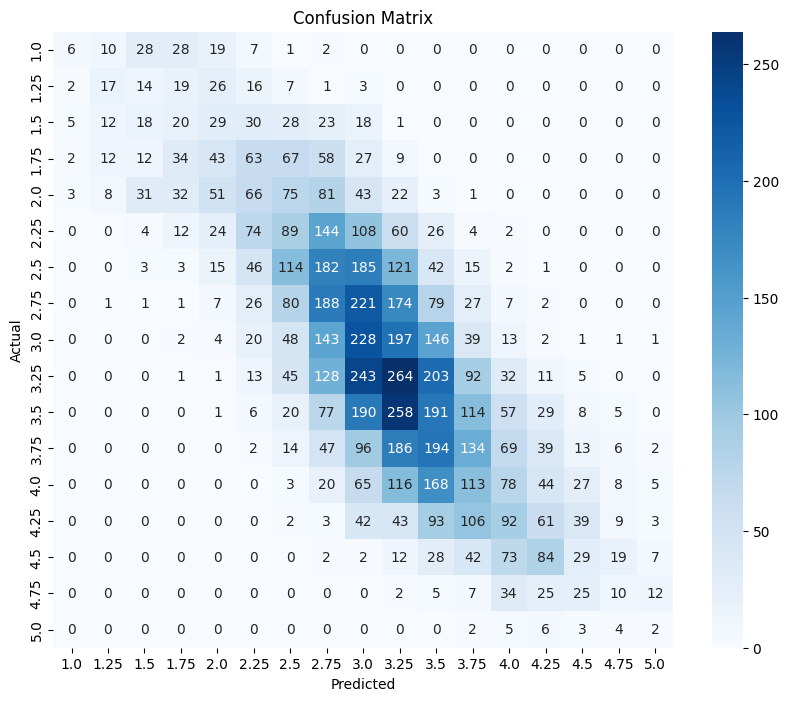

Accuracy: 0.1775
Mean Squared Error: 0.2954 and Mean Absolute Error: 0.4373


In [18]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
train_model(modelCNN, optimizer, num_epochs=200)

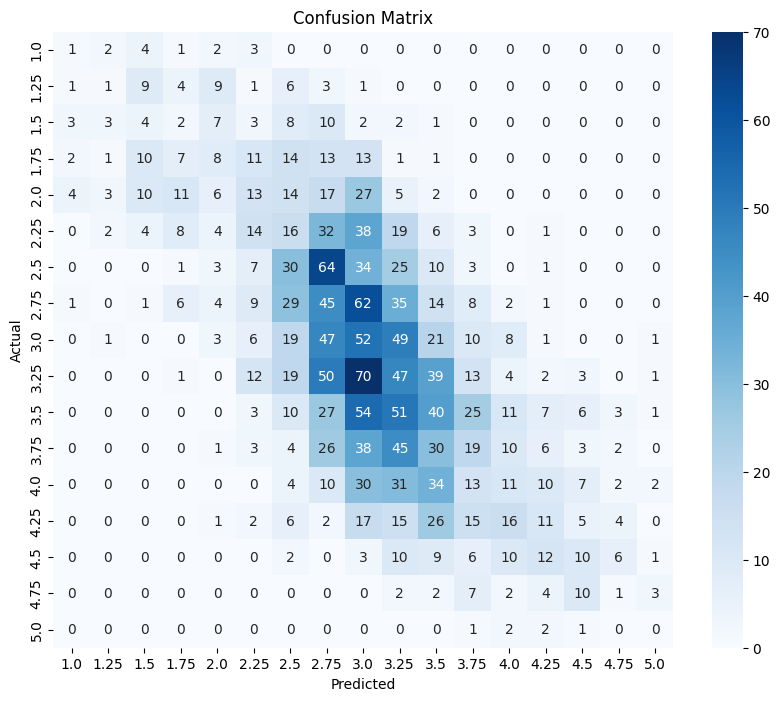

Accuracy: 0.1416


'Mean Squared Error: 0.4098 and Mean Absolute Error: 0.5145'

In [24]:
############################################################################################################
### Load the model
def load_model(epoch, save_dir='model_checkpoint'):
    model = CNN()
    optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=0.0001)  # Use the same optimizer as during training
    checkpoint = torch.load(os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move the loaded model to the device
    model.eval()
    return model, optimizer, epoch


loaded_epoch = 130  # Change this to the epoch you want to evaluate
loaded_model, loaded_optimizer, loaded_epoch = load_model(loaded_epoch)

# Evaluate the loaded model
evaluate_model(loaded_model, validation_loader, conf=True)

# Official Test Data

In [20]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/test'
test_label = {}
lenghts = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            test_label[filename] = data['audio_data']
            lenghts.append(len(data['audio_data']))
print(max(lenghts))
            

100%|██████████| 1863/1863 [00:19<00:00, 97.12it/s] 

133534


In [21]:
for recording_test in test_label:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(test_label[recording_test], (max_length // len(test_label[recording_test]) + 1))[:max_length]
    test_label[recording_test] = repeated_recording
    
for i in test_label:
    print(i, test_label[i].shape)



10011.pkl (174625,)
10025.pkl (174625,)
10033.pkl (174625,)
10036.pkl (174625,)
10043.pkl (174625,)
10067.pkl (174625,)
10074.pkl (174625,)
10079.pkl (174625,)
10083.pkl (174625,)
10090.pkl (174625,)
10092.pkl (174625,)
10097.pkl (174625,)
10099.pkl (174625,)
10110.pkl (174625,)
10116.pkl (174625,)
10120.pkl (174625,)
10149.pkl (174625,)
10179.pkl (174625,)
10184.pkl (174625,)
10189.pkl (174625,)
10191.pkl (174625,)
10192.pkl (174625,)
10194.pkl (174625,)
10200.pkl (174625,)
10202.pkl (174625,)
10204.pkl (174625,)
10206.pkl (174625,)
10207.pkl (174625,)
10216.pkl (174625,)
10222.pkl (174625,)
10224.pkl (174625,)
10235.pkl (174625,)
10236.pkl (174625,)
10240.pkl (174625,)
10242.pkl (174625,)
10251.pkl (174625,)
10253.pkl (174625,)
10259.pkl (174625,)
10267.pkl (174625,)
10271.pkl (174625,)
10277.pkl (174625,)
10279.pkl (174625,)
10286.pkl (174625,)
10287.pkl (174625,)
10288.pkl (174625,)
10290.pkl (174625,)
10291.pkl (174625,)
10293.pkl (174625,)
10306.pkl (174625,)
10315.pkl (174625,)


In [27]:
FinalTestAudio = []
for i in test_label:
    FinalTestAudio.append(test_label[i])

FinalTestDataset = torch.tensor(FinalTestAudio, dtype=torch.float32).unsqueeze(1)

results = predict(loaded_model, FinalTestDataset, device)
print(len(results))


1863


In [30]:
import pandas as pd
labels_final = test_label.keys()
labels_final = list(labels_final)   
df = pd.DataFrame({'ID': labels_final, 'Label': results})
df['Label'] = df['Label'].clip(lower=1, upper=5)
df.to_csv('results_best.csv', index=False)

In [203]:
df[df['ID']=="21084.pkl"]

,ID,Label
1667,21084.pkl,5.0


In [199]:
max(df['Label']), min(df['Label'])
df[df['Label'] > 5]


,ID,Label
1667,21084.pkl,5.069119
1763,21673.pkl,5.490522


In [198]:
df[df['Label'] < 1]

,ID,Label
13,10110.pkl,0.979741
424,12693.pkl,0.720084
481,13054.pkl,0.943736
546,13507.pkl,0.926584
564,13591.pkl,0.542841


  3%|▎         | 1/30 [00:13<06:44, 13.94s/it]

Epoch [1/30], Loss: 218.6098
--------------------------------------------------


  7%|▋         | 2/30 [00:22<04:53, 10.49s/it]

Epoch [2/30], Loss: 10.2590
--------------------------------------------------
Epoch [3/30], Loss: 9.8188


 10%|█         | 3/30 [00:33<04:52, 10.84s/it]

Validation: Mean Squared Error: 9.4935 and Mean Absolute Error: 2.9699
--------------------------------------------------
Epoch [4/30], Loss: 9.4264


 13%|█▎        | 4/30 [00:42<04:28, 10.33s/it]

Validation: Mean Squared Error: 9.1430 and Mean Absolute Error: 2.9103
--------------------------------------------------
Epoch [5/30], Loss: 9.1026


 17%|█▋        | 5/30 [00:52<04:08,  9.96s/it]

Validation: Mean Squared Error: 8.8477 and Mean Absolute Error: 2.8591
--------------------------------------------------
Epoch [6/30], Loss: 8.8253


 20%|██        | 6/30 [01:01<03:54,  9.77s/it]

Validation: Mean Squared Error: 8.5902 and Mean Absolute Error: 2.8137
--------------------------------------------------
Epoch [7/30], Loss: 8.5806


 23%|██▎       | 7/30 [01:10<03:40,  9.59s/it]

Validation: Mean Squared Error: 8.3602 and Mean Absolute Error: 2.7726
--------------------------------------------------
Epoch [8/30], Loss: 8.3601


 27%|██▋       | 8/30 [01:19<03:26,  9.39s/it]

Validation: Mean Squared Error: 8.1514 and Mean Absolute Error: 2.7346
--------------------------------------------------
Epoch [9/30], Loss: 8.1588


 30%|███       | 9/30 [01:28<03:13,  9.20s/it]

Validation: Mean Squared Error: 7.9595 and Mean Absolute Error: 2.6993
--------------------------------------------------
Epoch [10/30], Loss: 7.9725


 33%|███▎      | 10/30 [01:37<03:01,  9.07s/it]

Validation: Mean Squared Error: 7.7814 and Mean Absolute Error: 2.6661
--------------------------------------------------
Epoch [11/30], Loss: 7.7996


 37%|███▋      | 11/30 [01:46<02:50,  8.99s/it]

Validation: Mean Squared Error: 7.6151 and Mean Absolute Error: 2.6348
--------------------------------------------------
Epoch [12/30], Loss: 7.6368


 40%|████      | 12/30 [01:56<02:48,  9.35s/it]

Validation: Mean Squared Error: 7.4587 and Mean Absolute Error: 2.6049
--------------------------------------------------
Epoch [13/30], Loss: 7.4840


 43%|████▎     | 13/30 [02:05<02:36,  9.22s/it]

Validation: Mean Squared Error: 7.3111 and Mean Absolute Error: 2.5764
--------------------------------------------------
Epoch [14/30], Loss: 7.3396


 47%|████▋     | 14/30 [02:14<02:26,  9.15s/it]

Validation: Mean Squared Error: 7.1710 and Mean Absolute Error: 2.5491
--------------------------------------------------
Epoch [15/30], Loss: 7.2016


 50%|█████     | 15/30 [02:23<02:16,  9.09s/it]

Validation: Mean Squared Error: 7.0378 and Mean Absolute Error: 2.5228
--------------------------------------------------
Epoch [16/30], Loss: 7.0706


 53%|█████▎    | 16/30 [02:31<02:06,  9.01s/it]

Validation: Mean Squared Error: 6.9106 and Mean Absolute Error: 2.4975
--------------------------------------------------
Epoch [17/30], Loss: 6.9453


 57%|█████▋    | 17/30 [02:40<01:56,  8.97s/it]

Validation: Mean Squared Error: 6.7889 and Mean Absolute Error: 2.4730
--------------------------------------------------
Epoch [18/30], Loss: 6.8254


 60%|██████    | 18/30 [02:49<01:46,  8.91s/it]

Validation: Mean Squared Error: 6.6721 and Mean Absolute Error: 2.4493
--------------------------------------------------
Epoch [19/30], Loss: 6.7101


 63%|██████▎   | 19/30 [02:58<01:37,  8.90s/it]

Validation: Mean Squared Error: 6.5599 and Mean Absolute Error: 2.4263
--------------------------------------------------
Epoch [20/30], Loss: 6.5992


 67%|██████▋   | 20/30 [03:07<01:28,  8.88s/it]

Validation: Mean Squared Error: 6.4519 and Mean Absolute Error: 2.4039
--------------------------------------------------
Epoch [21/30], Loss: 6.4924


 70%|███████   | 21/30 [03:16<01:19,  8.85s/it]

Validation: Mean Squared Error: 6.3477 and Mean Absolute Error: 2.3821
--------------------------------------------------
Epoch [22/30], Loss: 6.3891


 73%|███████▎  | 22/30 [03:24<01:10,  8.85s/it]

Validation: Mean Squared Error: 6.2470 and Mean Absolute Error: 2.3609
--------------------------------------------------
Epoch [23/30], Loss: 6.2894


 77%|███████▋  | 23/30 [03:33<01:01,  8.84s/it]

Validation: Mean Squared Error: 6.1497 and Mean Absolute Error: 2.3402
--------------------------------------------------
Epoch [24/30], Loss: 6.1934


 80%|████████  | 24/30 [03:42<00:52,  8.83s/it]

Validation: Mean Squared Error: 6.0554 and Mean Absolute Error: 2.3200
--------------------------------------------------
Epoch [25/30], Loss: 6.0998


 83%|████████▎ | 25/30 [03:51<00:44,  8.84s/it]

Validation: Mean Squared Error: 5.9641 and Mean Absolute Error: 2.3002
--------------------------------------------------
Epoch [26/30], Loss: 6.0089


 87%|████████▋ | 26/30 [04:00<00:35,  8.83s/it]

Validation: Mean Squared Error: 5.8754 and Mean Absolute Error: 2.2809
--------------------------------------------------
Epoch [27/30], Loss: 5.9210


 90%|█████████ | 27/30 [04:09<00:26,  8.83s/it]

Validation: Mean Squared Error: 5.7893 and Mean Absolute Error: 2.2619
--------------------------------------------------
Epoch [28/30], Loss: 5.8356


 93%|█████████▎| 28/30 [04:17<00:17,  8.84s/it]

Validation: Mean Squared Error: 5.7056 and Mean Absolute Error: 2.2433
--------------------------------------------------
Epoch [29/30], Loss: 5.7523


 97%|█████████▋| 29/30 [04:26<00:08,  8.90s/it]

Validation: Mean Squared Error: 5.6242 and Mean Absolute Error: 2.2251
--------------------------------------------------
Epoch [30/30], Loss: 5.6714


100%|██████████| 30/30 [04:36<00:00,  9.20s/it]

Validation: Mean Squared Error: 5.5449 and Mean Absolute Error: 2.2072
--------------------------------------------------


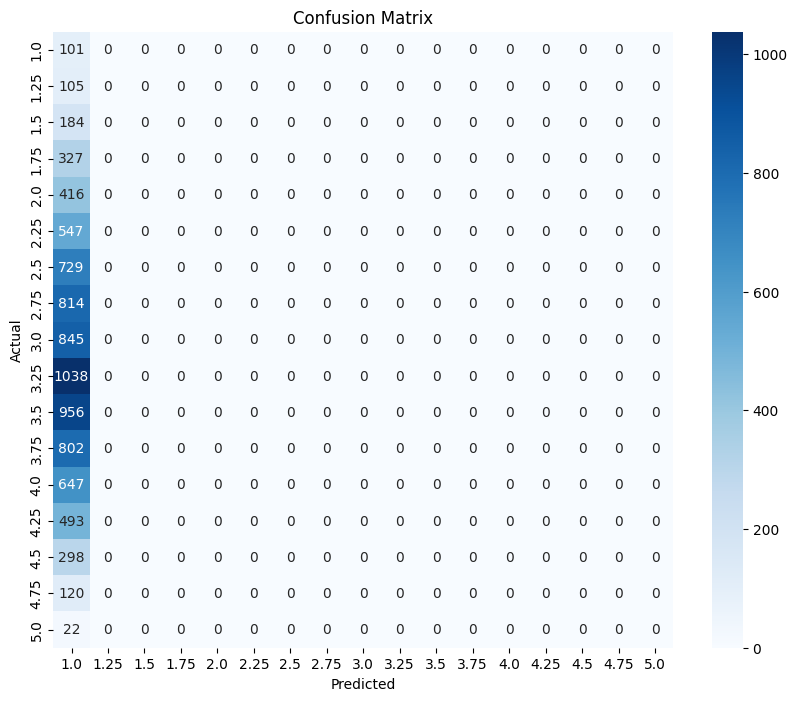

Accuracy: 0.0120
Mean Squared Error: 5.6304 and Mean Absolute Error: 2.2228


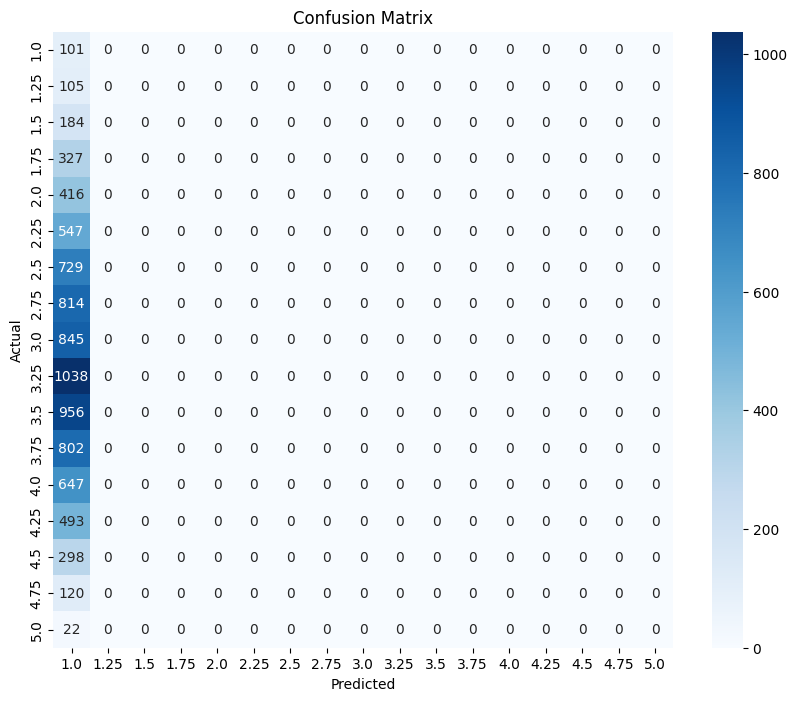

Accuracy: 0.0120


  3%|▎         | 1/30 [00:07<03:35,  7.42s/it]

Epoch [1/30], Loss: 5.3583
--------------------------------------------------


  7%|▋         | 2/30 [00:14<03:27,  7.42s/it]

Epoch [2/30], Loss: 5.0847
--------------------------------------------------
Epoch [3/30], Loss: 4.9086


 10%|█         | 3/30 [00:23<03:39,  8.12s/it]

Validation: Mean Squared Error: 4.7520 and Mean Absolute Error: 2.0204
--------------------------------------------------
Epoch [4/30], Loss: 4.7673


 13%|█▎        | 4/30 [00:32<03:40,  8.47s/it]

Validation: Mean Squared Error: 4.6234 and Mean Absolute Error: 1.9887
--------------------------------------------------
Epoch [5/30], Loss: 4.6457


 17%|█▋        | 5/30 [00:41<03:36,  8.68s/it]

Validation: Mean Squared Error: 4.5105 and Mean Absolute Error: 1.9604
--------------------------------------------------
Epoch [6/30], Loss: 4.5376


 20%|██        | 6/30 [00:50<03:28,  8.68s/it]

Validation: Mean Squared Error: 4.4087 and Mean Absolute Error: 1.9346
--------------------------------------------------
Epoch [7/30], Loss: 4.4395


 23%|██▎       | 7/30 [00:59<03:22,  8.82s/it]

Validation: Mean Squared Error: 4.3155 and Mean Absolute Error: 1.9106
--------------------------------------------------
Epoch [8/30], Loss: 4.3489


 27%|██▋       | 8/30 [01:08<03:13,  8.77s/it]

Validation: Mean Squared Error: 4.2289 and Mean Absolute Error: 1.8881
--------------------------------------------------
Epoch [9/30], Loss: 4.2645


 30%|███       | 9/30 [01:18<03:11,  9.11s/it]

Validation: Mean Squared Error: 4.1478 and Mean Absolute Error: 1.8668
--------------------------------------------------
Epoch [10/30], Loss: 4.1850


 33%|███▎      | 10/30 [01:25<02:53,  8.68s/it]

Validation: Mean Squared Error: 4.0714 and Mean Absolute Error: 1.8464
--------------------------------------------------
Epoch [11/30], Loss: 4.1100


 37%|███▋      | 11/30 [01:33<02:40,  8.47s/it]

Validation: Mean Squared Error: 3.9989 and Mean Absolute Error: 1.8272
--------------------------------------------------
Epoch [12/30], Loss: 4.0384


 40%|████      | 12/30 [01:41<02:28,  8.24s/it]

Validation: Mean Squared Error: 3.9298 and Mean Absolute Error: 1.8090
--------------------------------------------------
Epoch [13/30], Loss: 3.9703


 43%|████▎     | 13/30 [01:49<02:17,  8.10s/it]

Validation: Mean Squared Error: 3.8638 and Mean Absolute Error: 1.7915
--------------------------------------------------
Epoch [14/30], Loss: 3.9053


 47%|████▋     | 14/30 [01:57<02:08,  8.01s/it]

Validation: Mean Squared Error: 3.8005 and Mean Absolute Error: 1.7745
--------------------------------------------------
Epoch [15/30], Loss: 3.8423


 50%|█████     | 15/30 [02:04<01:59,  7.95s/it]

Validation: Mean Squared Error: 3.7396 and Mean Absolute Error: 1.7580
--------------------------------------------------
Epoch [16/30], Loss: 3.7820


 53%|█████▎    | 16/30 [02:12<01:50,  7.90s/it]

Validation: Mean Squared Error: 3.6809 and Mean Absolute Error: 1.7419
--------------------------------------------------
Epoch [17/30], Loss: 3.7238


 57%|█████▋    | 17/30 [02:20<01:42,  7.89s/it]

Validation: Mean Squared Error: 3.6243 and Mean Absolute Error: 1.7262
--------------------------------------------------
Epoch [18/30], Loss: 3.6676


 60%|██████    | 18/30 [02:28<01:34,  7.87s/it]

Validation: Mean Squared Error: 3.5695 and Mean Absolute Error: 1.7109
--------------------------------------------------
Epoch [19/30], Loss: 3.6131


 63%|██████▎   | 19/30 [02:36<01:26,  7.88s/it]

Validation: Mean Squared Error: 3.5163 and Mean Absolute Error: 1.6960
--------------------------------------------------
Epoch [20/30], Loss: 3.5603


 67%|██████▋   | 20/30 [02:44<01:18,  7.88s/it]

Validation: Mean Squared Error: 3.4648 and Mean Absolute Error: 1.6813
--------------------------------------------------
Epoch [21/30], Loss: 3.5090


 70%|███████   | 21/30 [02:52<01:11,  7.92s/it]

Validation: Mean Squared Error: 3.4148 and Mean Absolute Error: 1.6670
--------------------------------------------------
Epoch [22/30], Loss: 3.4591


 73%|███████▎  | 22/30 [03:00<01:03,  7.91s/it]

Validation: Mean Squared Error: 3.3661 and Mean Absolute Error: 1.6529
--------------------------------------------------
Epoch [23/30], Loss: 3.4106


 77%|███████▋  | 23/30 [03:08<00:55,  7.93s/it]

Validation: Mean Squared Error: 3.3187 and Mean Absolute Error: 1.6390
--------------------------------------------------
Epoch [24/30], Loss: 3.3636


 80%|████████  | 24/30 [03:15<00:47,  7.90s/it]

Validation: Mean Squared Error: 3.2726 and Mean Absolute Error: 1.6254
--------------------------------------------------
Epoch [25/30], Loss: 3.3175


 83%|████████▎ | 25/30 [03:23<00:39,  7.92s/it]

Validation: Mean Squared Error: 3.2276 and Mean Absolute Error: 1.6120
--------------------------------------------------
Epoch [26/30], Loss: 3.2725


 87%|████████▋ | 26/30 [03:31<00:31,  7.92s/it]

Validation: Mean Squared Error: 3.1837 and Mean Absolute Error: 1.5989
--------------------------------------------------
Epoch [27/30], Loss: 3.2288


 90%|█████████ | 27/30 [03:39<00:23,  7.94s/it]

Validation: Mean Squared Error: 3.1408 and Mean Absolute Error: 1.5865
--------------------------------------------------
Epoch [28/30], Loss: 3.1860


 93%|█████████▎| 28/30 [03:47<00:15,  7.91s/it]

Validation: Mean Squared Error: 3.0990 and Mean Absolute Error: 1.5743
--------------------------------------------------
Epoch [29/30], Loss: 3.1441


 97%|█████████▋| 29/30 [03:55<00:07,  7.93s/it]

Validation: Mean Squared Error: 3.0580 and Mean Absolute Error: 1.5622
--------------------------------------------------
Epoch [30/30], Loss: 3.1033


100%|██████████| 30/30 [04:03<00:00,  8.12s/it]

Validation: Mean Squared Error: 3.0180 and Mean Absolute Error: 1.5504
--------------------------------------------------


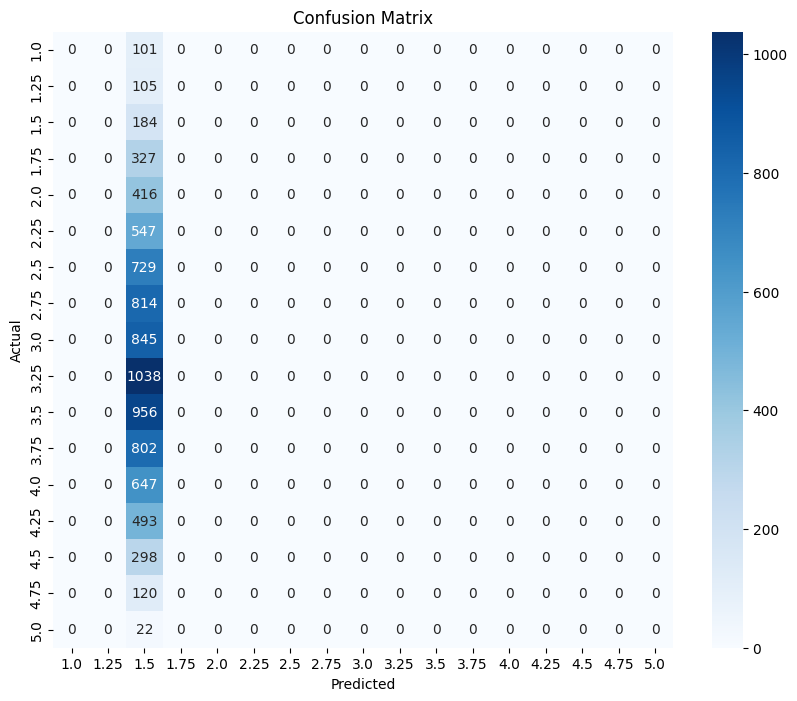

Accuracy: 0.0218
Mean Squared Error: 3.0825 and Mean Absolute Error: 1.5699


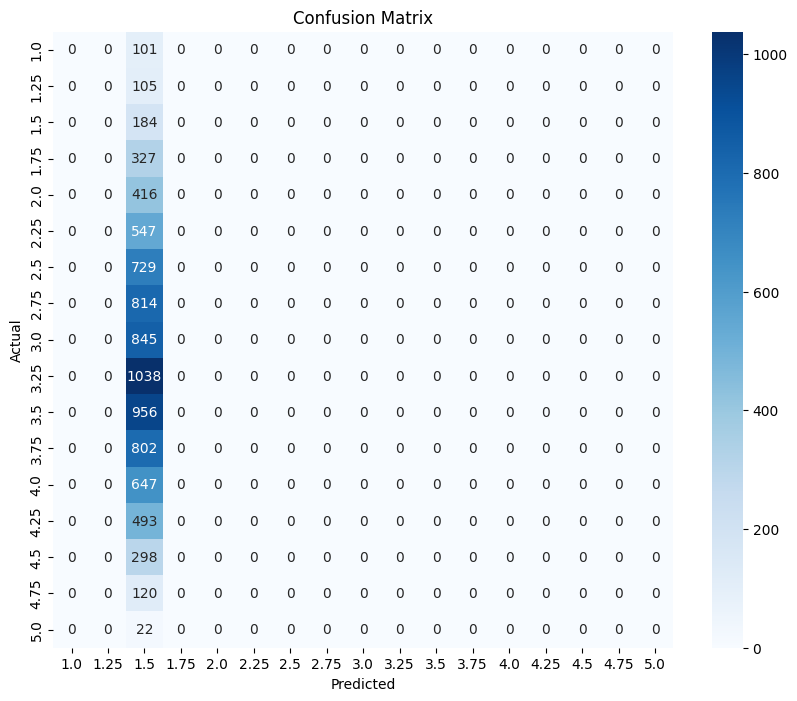

Accuracy: 0.0218


  3%|▎         | 1/30 [00:06<03:11,  6.61s/it]

Epoch [1/30], Loss: 3.0633
--------------------------------------------------


  7%|▋         | 2/30 [00:13<03:05,  6.61s/it]

Epoch [2/30], Loss: 3.0437
--------------------------------------------------
Epoch [3/30], Loss: 3.0308


 10%|█         | 3/30 [00:21<03:14,  7.19s/it]

Validation: Mean Squared Error: 2.9614 and Mean Absolute Error: 1.5334
--------------------------------------------------
Epoch [4/30], Loss: 3.0204


 13%|█▎        | 4/30 [00:28<03:13,  7.46s/it]

Validation: Mean Squared Error: 2.9519 and Mean Absolute Error: 1.5305
--------------------------------------------------
Epoch [5/30], Loss: 3.0114


 17%|█▋        | 5/30 [00:36<03:10,  7.62s/it]

Validation: Mean Squared Error: 2.9435 and Mean Absolute Error: 1.5280
--------------------------------------------------
Epoch [6/30], Loss: 3.0035


 20%|██        | 6/30 [00:44<03:04,  7.70s/it]

Validation: Mean Squared Error: 2.9359 and Mean Absolute Error: 1.5257
--------------------------------------------------
Epoch [7/30], Loss: 2.9962


 23%|██▎       | 7/30 [00:52<02:58,  7.75s/it]

Validation: Mean Squared Error: 2.9289 and Mean Absolute Error: 1.5236
--------------------------------------------------
Epoch [8/30], Loss: 2.9892


 27%|██▋       | 8/30 [01:00<02:51,  7.79s/it]

Validation: Mean Squared Error: 2.9224 and Mean Absolute Error: 1.5216
--------------------------------------------------
Epoch [9/30], Loss: 2.9829


 30%|███       | 9/30 [01:08<02:44,  7.81s/it]

Validation: Mean Squared Error: 2.9162 and Mean Absolute Error: 1.5197
--------------------------------------------------
Epoch [10/30], Loss: 2.9767


 33%|███▎      | 10/30 [01:16<02:37,  7.88s/it]

Validation: Mean Squared Error: 2.9103 and Mean Absolute Error: 1.5179
--------------------------------------------------
Epoch [11/30], Loss: 2.9709


 37%|███▋      | 11/30 [01:24<02:29,  7.89s/it]

Validation: Mean Squared Error: 2.9047 and Mean Absolute Error: 1.5162
--------------------------------------------------
Epoch [12/30], Loss: 2.9654


 40%|████      | 12/30 [01:32<02:22,  7.91s/it]

Validation: Mean Squared Error: 2.8993 and Mean Absolute Error: 1.5146
--------------------------------------------------
Epoch [13/30], Loss: 2.9600


 43%|████▎     | 13/30 [01:40<02:14,  7.90s/it]

Validation: Mean Squared Error: 2.8942 and Mean Absolute Error: 1.5130
--------------------------------------------------
Epoch [14/30], Loss: 2.9549


 47%|████▋     | 14/30 [01:48<02:06,  7.92s/it]

Validation: Mean Squared Error: 2.8892 and Mean Absolute Error: 1.5114
--------------------------------------------------
Epoch [15/30], Loss: 2.9498


 50%|█████     | 15/30 [01:55<01:58,  7.90s/it]

Validation: Mean Squared Error: 2.8843 and Mean Absolute Error: 1.5100
--------------------------------------------------
Epoch [16/30], Loss: 2.9450


 53%|█████▎    | 16/30 [02:03<01:51,  7.94s/it]

Validation: Mean Squared Error: 2.8796 and Mean Absolute Error: 1.5085
--------------------------------------------------
Epoch [17/30], Loss: 2.9404


 57%|█████▋    | 17/30 [02:11<01:43,  7.93s/it]

Validation: Mean Squared Error: 2.8751 and Mean Absolute Error: 1.5071
--------------------------------------------------
Epoch [18/30], Loss: 2.9358


 60%|██████    | 18/30 [02:19<01:35,  7.93s/it]

Validation: Mean Squared Error: 2.8706 and Mean Absolute Error: 1.5058
--------------------------------------------------
Epoch [19/30], Loss: 2.9315


 63%|██████▎   | 19/30 [02:27<01:27,  7.91s/it]

Validation: Mean Squared Error: 2.8663 and Mean Absolute Error: 1.5044
--------------------------------------------------
Epoch [20/30], Loss: 2.9271


 67%|██████▋   | 20/30 [02:35<01:19,  7.93s/it]

Validation: Mean Squared Error: 2.8621 and Mean Absolute Error: 1.5031
--------------------------------------------------
Epoch [21/30], Loss: 2.9228


 70%|███████   | 21/30 [02:43<01:11,  7.92s/it]

Validation: Mean Squared Error: 2.8579 and Mean Absolute Error: 1.5018
--------------------------------------------------
Epoch [22/30], Loss: 2.9186


 73%|███████▎  | 22/30 [02:51<01:03,  7.96s/it]

Validation: Mean Squared Error: 2.8539 and Mean Absolute Error: 1.5006
--------------------------------------------------
Epoch [23/30], Loss: 2.9146


 77%|███████▋  | 23/30 [02:59<00:55,  7.98s/it]

Validation: Mean Squared Error: 2.8499 and Mean Absolute Error: 1.4994
--------------------------------------------------
Epoch [24/30], Loss: 2.9107


 80%|████████  | 24/30 [03:07<00:47,  7.97s/it]

Validation: Mean Squared Error: 2.8460 and Mean Absolute Error: 1.4982
--------------------------------------------------
Epoch [25/30], Loss: 2.9068


 83%|████████▎ | 25/30 [03:15<00:39,  7.95s/it]

Validation: Mean Squared Error: 2.8421 and Mean Absolute Error: 1.4970
--------------------------------------------------
Epoch [26/30], Loss: 2.9028


 87%|████████▋ | 26/30 [03:23<00:31,  7.92s/it]

Validation: Mean Squared Error: 2.8384 and Mean Absolute Error: 1.4958
--------------------------------------------------
Epoch [27/30], Loss: 2.8991


 90%|█████████ | 27/30 [03:31<00:23,  7.89s/it]

Validation: Mean Squared Error: 2.8347 and Mean Absolute Error: 1.4946
--------------------------------------------------
Epoch [28/30], Loss: 2.8955


 93%|█████████▎| 28/30 [03:38<00:15,  7.87s/it]

Validation: Mean Squared Error: 2.8310 and Mean Absolute Error: 1.4935
--------------------------------------------------
Epoch [29/30], Loss: 2.8917


 97%|█████████▋| 29/30 [03:46<00:07,  7.85s/it]

Validation: Mean Squared Error: 2.8274 and Mean Absolute Error: 1.4924
--------------------------------------------------
Epoch [30/30], Loss: 2.8882


100%|██████████| 30/30 [03:54<00:00,  7.82s/it]

Validation: Mean Squared Error: 2.8239 and Mean Absolute Error: 1.4913
--------------------------------------------------


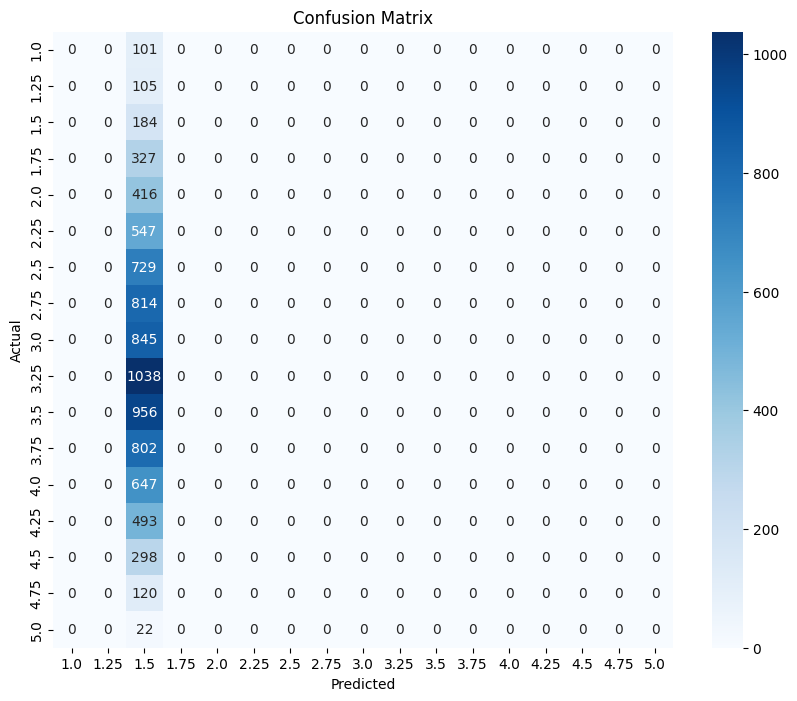

Accuracy: 0.0218
Mean Squared Error: 2.8863 and Mean Absolute Error: 1.5112


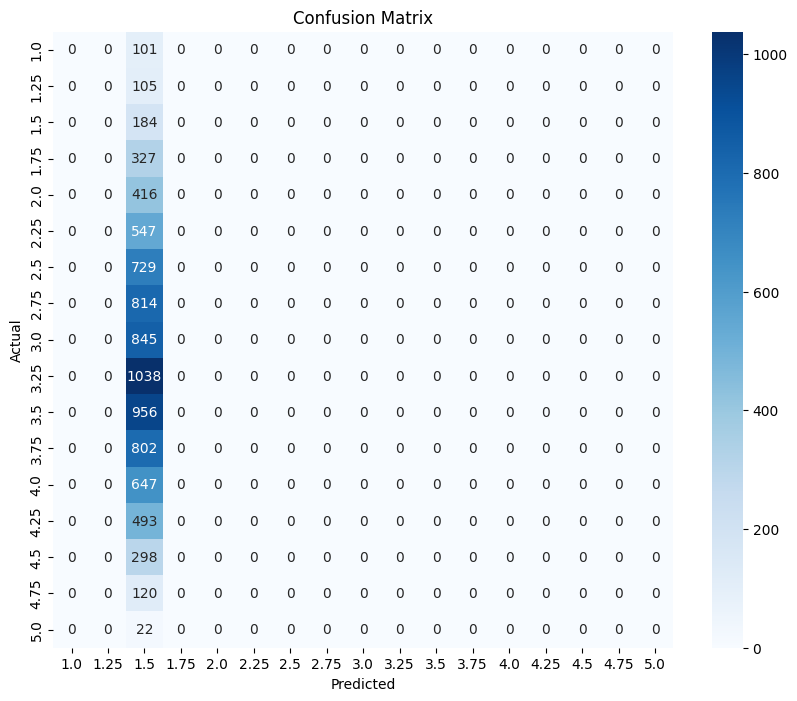

Accuracy: 0.0218


  3%|▎         | 1/30 [00:06<03:08,  6.49s/it]

Epoch [1/30], Loss: 2.8679
--------------------------------------------------


  7%|▋         | 2/30 [00:13<03:03,  6.54s/it]

Epoch [2/30], Loss: 2.8492
--------------------------------------------------
Epoch [3/30], Loss: 2.8369


 10%|█         | 3/30 [00:20<03:13,  7.15s/it]

Validation: Mean Squared Error: 2.7697 and Mean Absolute Error: 1.4744
--------------------------------------------------
Epoch [4/30], Loss: 2.8270


 13%|█▎        | 4/30 [00:28<03:13,  7.43s/it]

Validation: Mean Squared Error: 2.7607 and Mean Absolute Error: 1.4715
--------------------------------------------------
Epoch [5/30], Loss: 2.8184


 17%|█▋        | 5/30 [00:36<03:09,  7.57s/it]

Validation: Mean Squared Error: 2.7528 and Mean Absolute Error: 1.4690
--------------------------------------------------
Epoch [6/30], Loss: 2.8109


 20%|██        | 6/30 [00:44<03:06,  7.79s/it]

Validation: Mean Squared Error: 2.7455 and Mean Absolute Error: 1.4667
--------------------------------------------------
Epoch [7/30], Loss: 2.8039


 23%|██▎       | 7/30 [00:52<02:59,  7.81s/it]

Validation: Mean Squared Error: 2.7389 and Mean Absolute Error: 1.4646
--------------------------------------------------
Epoch [8/30], Loss: 2.7974


 27%|██▋       | 8/30 [01:00<02:52,  7.84s/it]

Validation: Mean Squared Error: 2.7327 and Mean Absolute Error: 1.4626
--------------------------------------------------
Epoch [9/30], Loss: 2.7914


 30%|███       | 9/30 [01:20<04:02, 11.56s/it]

Validation: Mean Squared Error: 2.7269 and Mean Absolute Error: 1.4608
--------------------------------------------------
Epoch [10/30], Loss: 2.7855


 33%|███▎      | 10/30 [01:32<03:56, 11.81s/it]

Validation: Mean Squared Error: 2.7213 and Mean Absolute Error: 1.4590
--------------------------------------------------
Epoch [11/30], Loss: 2.7801


 37%|███▋      | 11/30 [01:43<03:36, 11.42s/it]

Validation: Mean Squared Error: 2.7160 and Mean Absolute Error: 1.4573
--------------------------------------------------
Epoch [12/30], Loss: 2.7749


 40%|████      | 12/30 [01:53<03:19, 11.08s/it]

Validation: Mean Squared Error: 2.7110 and Mean Absolute Error: 1.4557
--------------------------------------------------
Epoch [13/30], Loss: 2.7698


 43%|████▎     | 13/30 [02:05<03:10, 11.22s/it]

Validation: Mean Squared Error: 2.7061 and Mean Absolute Error: 1.4542
--------------------------------------------------
Epoch [14/30], Loss: 2.7650


 47%|████▋     | 14/30 [02:17<03:03, 11.45s/it]

Validation: Mean Squared Error: 2.7014 and Mean Absolute Error: 1.4527
--------------------------------------------------
Epoch [15/30], Loss: 2.7602


 50%|█████     | 15/30 [02:28<02:50, 11.38s/it]

Validation: Mean Squared Error: 2.6969 and Mean Absolute Error: 1.4512
--------------------------------------------------
Epoch [16/30], Loss: 2.7557


 53%|█████▎    | 16/30 [02:40<02:41, 11.56s/it]

Validation: Mean Squared Error: 2.6925 and Mean Absolute Error: 1.4498
--------------------------------------------------
Epoch [17/30], Loss: 2.7513


 57%|█████▋    | 17/30 [02:51<02:28, 11.44s/it]

Validation: Mean Squared Error: 2.6882 and Mean Absolute Error: 1.4484
--------------------------------------------------
Epoch [18/30], Loss: 2.7471


 60%|██████    | 18/30 [03:03<02:17, 11.49s/it]

Validation: Mean Squared Error: 2.6841 and Mean Absolute Error: 1.4471
--------------------------------------------------
Epoch [19/30], Loss: 2.7431


 63%|██████▎   | 19/30 [03:13<02:03, 11.27s/it]

Validation: Mean Squared Error: 2.6800 and Mean Absolute Error: 1.4458
--------------------------------------------------
Epoch [20/30], Loss: 2.7390


 67%|██████▋   | 20/30 [03:24<01:50, 11.07s/it]

Validation: Mean Squared Error: 2.6761 and Mean Absolute Error: 1.4445
--------------------------------------------------
Epoch [21/30], Loss: 2.7349


 70%|███████   | 21/30 [03:34<01:36, 10.73s/it]

Validation: Mean Squared Error: 2.6722 and Mean Absolute Error: 1.4433
--------------------------------------------------
Epoch [22/30], Loss: 2.7310


 73%|███████▎  | 22/30 [03:43<01:23, 10.40s/it]

Validation: Mean Squared Error: 2.6684 and Mean Absolute Error: 1.4421
--------------------------------------------------
Epoch [23/30], Loss: 2.7273


 77%|███████▋  | 23/30 [03:53<01:10, 10.11s/it]

Validation: Mean Squared Error: 2.6647 and Mean Absolute Error: 1.4409
--------------------------------------------------
Epoch [24/30], Loss: 2.7237


 80%|████████  | 24/30 [04:02<00:59,  9.92s/it]

Validation: Mean Squared Error: 2.6611 and Mean Absolute Error: 1.4397
--------------------------------------------------
Epoch [25/30], Loss: 2.7200


 83%|████████▎ | 25/30 [04:12<00:48,  9.77s/it]

Validation: Mean Squared Error: 2.6575 and Mean Absolute Error: 1.4385
--------------------------------------------------
Epoch [26/30], Loss: 2.7163


 87%|████████▋ | 26/30 [04:20<00:36,  9.21s/it]

Validation: Mean Squared Error: 2.6540 and Mean Absolute Error: 1.4374
--------------------------------------------------
Epoch [27/30], Loss: 2.7129


 90%|█████████ | 27/30 [04:28<00:26,  8.80s/it]

Validation: Mean Squared Error: 2.6506 and Mean Absolute Error: 1.4363
--------------------------------------------------
Epoch [28/30], Loss: 2.7096


 93%|█████████▎| 28/30 [04:36<00:17,  8.55s/it]

Validation: Mean Squared Error: 2.6472 and Mean Absolute Error: 1.4352
--------------------------------------------------
Epoch [29/30], Loss: 2.7060


 97%|█████████▋| 29/30 [04:44<00:08,  8.39s/it]

Validation: Mean Squared Error: 2.6438 and Mean Absolute Error: 1.4341
--------------------------------------------------
Epoch [30/30], Loss: 2.7027


100%|██████████| 30/30 [04:51<00:00,  9.73s/it]

Validation: Mean Squared Error: 2.6406 and Mean Absolute Error: 1.4330
--------------------------------------------------


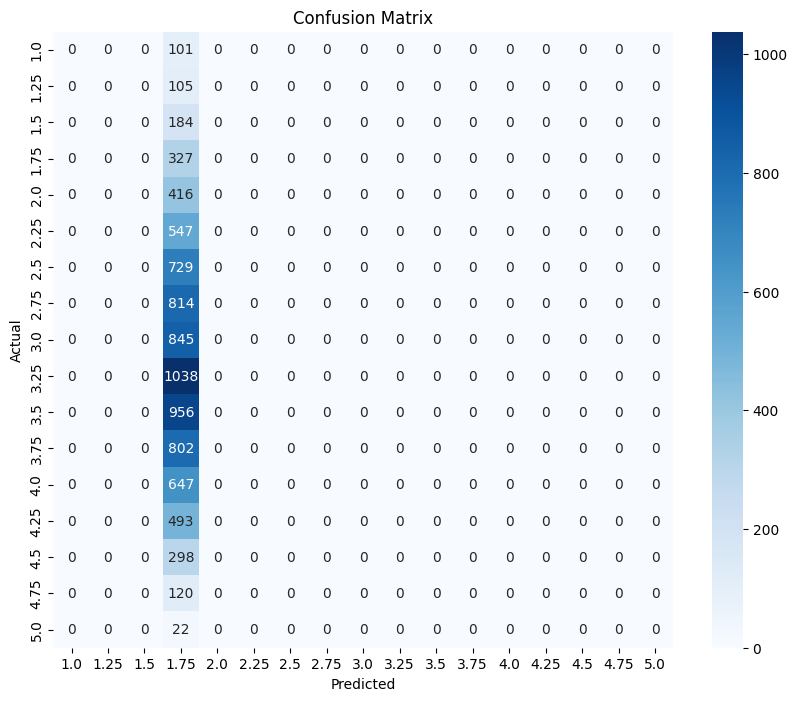

Accuracy: 0.0387
Mean Squared Error: 2.7010 and Mean Absolute Error: 1.4532


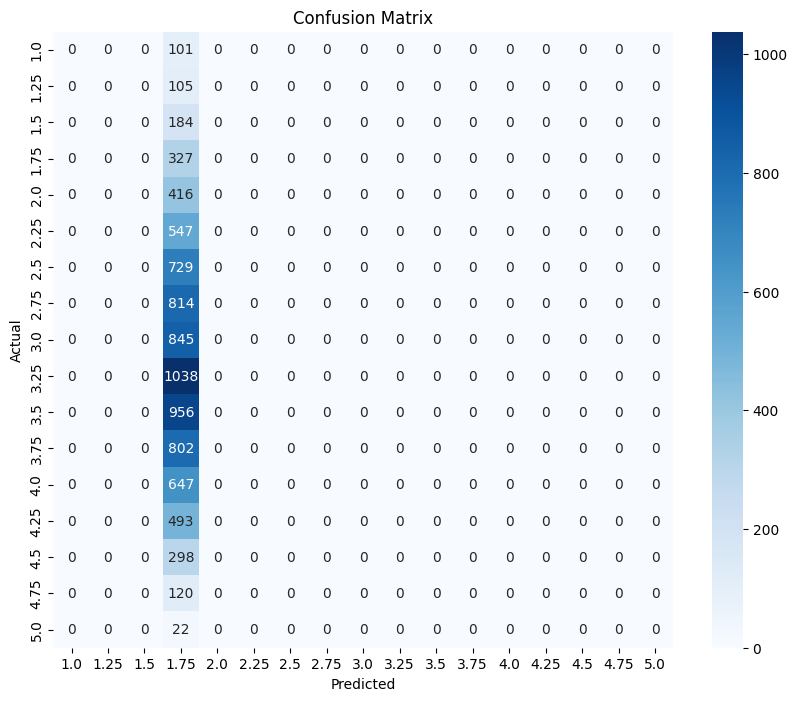

Accuracy: 0.0387
Learning Rate	Weight Decay	MSE
0.001		0.0001		Mean Squared Error: 2.7010 and Mean Absolute Error: 1.4532
0.001		0.001		Mean Squared Error: 2.8863 and Mean Absolute Error: 1.5112
0.01		0.0001		Mean Squared Error: 3.0825 and Mean Absolute Error: 1.5699
0.01		0.001		Mean Squared Error: 5.6304 and Mean Absolute Error: 2.2228


In [42]:
# Define learning rates and weight decays to search
learning_rates = [0.01, 0.001]
weight_decays = [0.001, 0.0001]

# Dictionary to store MSE values for each combination
mse_results = {}

# Iterate over each combination of hyperparameters
for lr in learning_rates:
    for weight_decay in weight_decays:
        # Create the model and optimizer with the current hyperparameters
        loaded_model = CNN().to(device)
        optimizer = optim.Adagrad(modelCNN.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Train the model
        train_model(modelCNN, optimizer, num_epochs=30)
        
        # Evaluate the model
        mse = evaluate_model(modelCNN, train_loader, conf=True)
        
        # Store the MSE value for the current combination of hyperparameters
        mse_results[(lr, weight_decay)] = mse

# Print the MSE values in a table
print("Learning Rate\tWeight Decay\tMSE")
for lr, weight_decay in sorted(mse_results.keys()):
    mse = mse_results[(lr, weight_decay)]
    print(f"{lr}\t\t{weight_decay}\t\t{mse}")

In [41]:
loaded_model

CNN(
  (mfcc_transform): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layers): ModuleList(
    (0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(24, 64, kernel_size=(7,), stride=(1,), padding=(1,))
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=False)
    (6): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runn